# Loading dataset

In [ ]:
# First, let's install pydrive module to acces google drive directory
! pip install pydrive

In [ ]:
# Let's create an access to google drive

import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# Test Set .tar
# Use the file ID to transfer the file from GoogleDrive to Colab
download = drive.CreateFile({'id': '1uekiAYzq3r-YmIFOMsf887JyloGmUvB0'})
# Download the file and save with the specific name 'test.tar'
download.GetContentFile('test.tar')


# Train Set .tar
# Use the file ID to transfer the file from GoogleDrive to Colab
download = drive.CreateFile({'id': '1zwhiNz6H1-dm7HAsUopol2vC-e6mFC4c'})
# Download the file and save with the specific name 'train.tar'
download.GetContentFile('train.tar')


# Valid Set .tar
# Use the file ID to transfer the file from GoogleDrive to Colab
download = drive.CreateFile({'id': '1qkFCkVxgKcrZcbLDzJULLbivm80KWfu-'})
# Download the file and save with the specific name 'valid.tar'
download.GetContentFile('valid.tar')


# Upload and Extract .tar files in content/cell_images folder

In [ ]:
# Upload test.tar from Google Drive to colab
upload = drive.CreateFile({'title': 'test.tar'})
upload.SetContentFile('test.tar')
upload.Upload()

# Let's create a directory to extract our dataset
! mkdir -p content/cell_images

#Extract content test.tar
!tar -xvf  test.tar -C content/cell_images


# Upload train.tar from Google Drive to colab
upload = drive.CreateFile({'title': 'train.tar'})
upload.SetContentFile('train.tar')
upload.Upload()

#Extract content test.tar
!tar -xvf  train.tar -C content/cell_images


# Upload valid.tar from Google Drive to colab
upload = drive.CreateFile({'title': 'valid.tar'})
upload.SetContentFile('valid.tar')
upload.Upload()

#Extract content test.tar
!tar -xvf  valid.tar -C content/cell_images

In [ ]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    malaria_files = np.array(data['filenames'])
    malaria_targets = np_utils.to_categorical(np.array(data['target']), 2)
    return malaria_files, malaria_targets

train_path = 'content/cell_images/r_train'
valid_path = 'content/cell_images/r_valid'
test_path = 'content/cell_images/r_test'

train_files, train_targets = load_dataset(train_path)
valid_files, valid_targets = load_dataset(valid_path)
test_files, test_targets = load_dataset(test_path)

print(f'Full data shape: {len(train_files) + len(valid_files) +len(test_files)} |' 
      f'Full data target shape: {len(train_targets) + len(valid_targets) + len(test_targets)}')
print(f'Train shape: {len(train_files)} | Train Target shape: {len(train_targets)}')
print(f'Valid shape: {len(valid_files)} | Valid Target shape: {len(valid_targets)}')
print(f'Test shape: {len(test_files)}  | Test Target shape: {len(test_targets)}') 



Using TensorFlow backend.


Full data shape: 27558 |Full data target shape: 27558
Train shape: 19290 | Train Target shape: 19290
Valid shape: 2756 | Valid Target shape: 2756
Test shape: 5512  | Test Target shape: 5512


# Pre-process the data

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

#Define a ImageDataGenerator for each dataset. 
#This augmentation process is only to rescale each imagem to 1/255

datagen_train = ImageDataGenerator(rescale=1./255)
datagen_test = ImageDataGenerator(rescale=1./255)
datagen_valid = ImageDataGenerator(rescale=1./255)

#Let's Create a ImageDataGenerator Just for visualize (without rescale)
just_for_visualize = ImageDataGenerator()
just_for_visualize_generator = just_for_visualize.flow_from_directory(
    'content/cell_images/r_train', #Train folder path 
    target_size=(150,150))



#Define a batch_size parameter
batch_size=32

# Here .flow_from_directory is used to transform 
train_generator = datagen_train.flow_from_directory(
    'content/cell_images/r_train', #Train folder path 
    target_size=(150,150), #all images will be resized to 224x224
    batch_size=batch_size,
    class_mode='categorical') # We use categorical_crossentropy loss, 
                              # we need categorical labels


test_generator = datagen_test.flow_from_directory(
    'content/cell_images/r_test', #Test folder path
    target_size=(150,150), #all images will be resized to 224x224
    batch_size=52,
    class_mode='categorical',
    shuffle=False) 

valid_generator = datagen_valid.flow_from_directory(
    'content/cell_images/r_valid', #all images will be resized to 224x224
    target_size=(150,150),
    batch_size=26,
    class_mode='categorical') 
    




Found 19290 images belonging to 2 classes.
Found 19290 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


# Visualizing some images

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


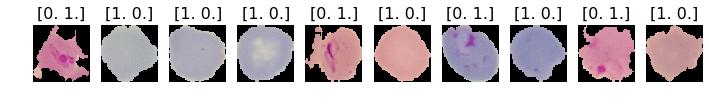

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import keras
from keras.preprocessing.image import ImageDataGenerator

# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(just_for_visualize_generator)
plots(imgs[:10], titles=labels)


# Create a VGG16 model
---



In [ ]:
from keras.applications.vgg16 import VGG16
input_shape = (150, 150, 3)

vgg16 = VGG16(include_top=False, input_shape=input_shape)

vgg16.summary()


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_____

### Cut the final layers from VGG16

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense

vgg16_model = Sequential()
for layers in vgg16.layers:
    vgg16_model.add(layers)
    
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

### Freeze the weights    


In [ ]:
for layers in vgg16_model.layers:
    layers.trainable = False

### Add a flatten layer and dense layers

In [ ]:
vgg16_model.add(Flatten())

vgg16_model.add(Dense(128, activation='relu'))
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Dense(64, activation='relu'))
vgg16_model.add(Dropout(0.3))

vgg16_model.add(Dense(2, activation='softmax'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Compile the model

In [ ]:
from keras.optimizers import RMSprop

rmsprop = RMSprop(lr=0.001)

vgg16_model.compile(loss='categorical_crossentropy', optimizer=rmsprop, 
                  metrics=['accuracy'])
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 37, 37, 256)       295168    
__________

In [ ]:
for layer in vgg16_model.layers:
    print(layer.name, layer.trainable)

block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False
flatten_1 True
dense_1 True
dropout_1 True
dense_2 True
dropout_2 True
dense_3 True


## Train the model

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define epochs number
epochs = 20


# Create a checkpointer to save only the best params
checkpointer = ModelCheckpoint(filepath='tf_learning_model.weights.best.hdf5', 
                              verbose=1, save_best_only=True)

history_m2 = vgg16_model.fit_generator(train_generator,
                   steps_per_epoch=train_generator.samples//batch_size,
                   epochs=epochs,
                   callbacks=[checkpointer],
                   validation_data=valid_generator,
                   validation_steps=106)



Instructions for updating:
Use tf.cast instead.
Epoch 1/20
602/602 [==============================] - 66s 110ms/step - loss: 0.3880 - acc: 0.8302 - val_loss: 0.6123 - val_acc: 0.7231

Epoch 00001: val_loss improved from inf to 0.61234, saving model to tf_learning_model.weights.best.hdf5
Epoch 2/20
602/602 [==============================] - 59s 98ms/step - loss: 0.2467 - acc: 0.9074 - val_loss: 0.3156 - val_acc: 0.8741

Epoch 00002: val_loss improved from 0.61234 to 0.31560, saving model to tf_learning_model.weights.best.hdf5
Epoch 3/20
602/602 [==============================] - 60s 99ms/step - loss: 0.2169 - acc: 0.9204 - val_loss: 0.2486 - val_acc: 0.9097

Epoch 00003: val_loss improved from 0.31560 to 0.24857, saving model to tf_learning_model.weights.best.hdf5
Epoch 4/20
602/602 [==============================] - 60s 100ms/step - loss: 0.2065 - acc: 0.9246 - val_loss: 0.2635 - val_acc: 0.9020

Epoch 00004: val_loss did not improve from 0.24857
Epoch 5/20
602/602 [===================

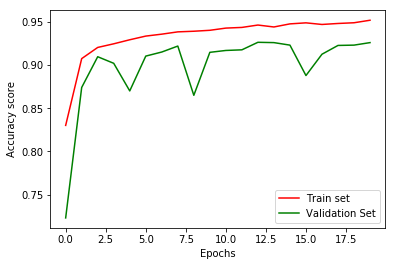

In [ ]:
plt.plot(history_m2.history['acc'], color='red', label='Train set')
plt.plot(history_m2.history['val_acc'], color='green', label='Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy score')
plt.legend()

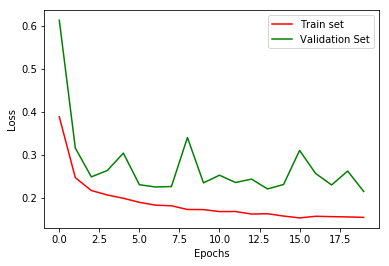

In [ ]:
plt.plot(history_m2.history['loss'], color='red', label='Train set')
plt.plot(history_m2.history['val_loss'], color='green', label='Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Load the model with the best validation accuracy

In [ ]:
# load the weights that yielded the best validation accuracy
vgg16_model.load_weights('tf_learning_model.weights.best.hdf5')


##Evaluate the model

In [ ]:
valid_generator = datagen_valid.flow_from_directory(
    'content/cell_images/r_valid', #all images will be resized to 150x150
    target_size=(150,150),
    batch_size=26,
    class_mode='categorical',
    shuffle=False)


#evaluate and print test accuracy
score = vgg16_model.evaluate_generator(valid_generator, steps=106)
print('\n', 'Valid accuracy:', score[1])

#evaluate and print test accuracy
score = vgg16_model.evaluate_generator(test_generator, steps=106)
print('\n', 'Test accuracy:', score[1])


Found 2756 images belonging to 2 classes.

 Valid accuracy: 0.9259796704886094

 Test accuracy: 0.9270682143715193


### Predict values on test set and create a confusion matrix

In [ ]:
# Let's use a function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[2702   54]
 [ 348 2408]]


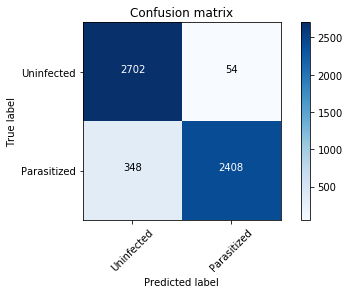

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_generator.reset()

predictions = vgg16_model.predict_generator(test_generator, steps=106)
y_predictions = np.argmax(predictions, axis=1)

confusion_matrix = confusion_matrix(test_generator.classes, y_predictions)
classe_names = ['Uninfected', 'Parasitized']
plot_confusion_matrix(confusion_matrix, classe_names)

In [ ]:
print(classification_report(test_generator.classes, y_predictions, target_names=classe_names))

print(f'Accuracy score: {accuracy_score(test_generator.classes, y_predictions)}')

              precision    recall  f1-score   support

  Uninfected       0.88      0.98      0.93      2756
 Parasitized       0.98      0.87      0.92      2756

   micro avg       0.93      0.93      0.93      5512
   macro avg       0.93      0.93      0.93      5512
weighted avg       0.93      0.93      0.93      5512

Accuracy score: 0.9254354136429608


###ROC curve

In [ ]:
predictions_only_true = predictions[:,1]
predictions_only_true

array([2.6393970e-04, 2.7522562e-02, 3.6067031e-03, ..., 9.8999596e-01,
       7.0157284e-01, 9.9989760e-01], dtype=float32)

Area under the curve: 0.9840540549080407


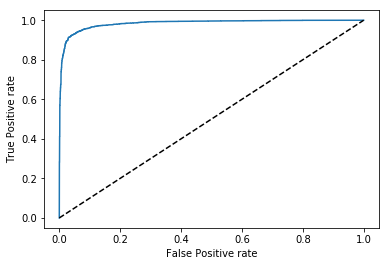

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, threshold = roc_curve(test_generator.classes, predictions_only_true)
area_uc = roc_auc_score(test_generator.classes, predictions_only_true)
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--', color='black')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
print(f'Area under the curve: {area_uc}')